In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from scipy.special import softmax

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Function to convert string representation of arrays to actual arrays
def parse_array(s):
    # Handling multi-row array strings
    return np.array([np.fromstring(line.strip(' []'), sep=' ') for line in s.splitlines()])

def get_performace(data_path):
    # Load the data
    data = pd.read_csv(data_path)

    # Parse 'Prediction' and 'True Value' columns
    data['Prediction'] = data['Prediction'].apply(parse_array)
    data['True Value'] = data['True Value'].apply(parse_array)

    # Extract epoch numbers to calculate metrics per epoch
    epochs = data['Epoch'].unique()

    # Dictionary to store performance metrics for each epoch
    performance_metrics = {}

    for epoch in epochs:
        # Filter data for the current epoch
        epoch_data = data[data['Epoch'] == epoch]
        predicted_scores = np.vstack(epoch_data['Prediction'])
        true_labels = np.vstack(epoch_data['True Value'])

        # Find the index of the maximum value in each prediction array
        predicted_labels = np.argmax(predicted_scores, axis=1)
        predicted_labels_proba = softmax(predicted_scores, axis=1)
        true_labels_flat = np.argmax(true_labels, axis=1)

        # Calculate performance metrics
        accuracy = accuracy_score(true_labels_flat, predicted_labels)
        precision = precision_score(true_labels_flat, predicted_labels, average='macro')
        recall = recall_score(true_labels_flat, predicted_labels, average='macro')
        f1 = f1_score(true_labels_flat, predicted_labels, average='macro')
        auc = roc_auc_score(true_labels, predicted_labels_proba, multi_class='ovr')
        cm = confusion_matrix(true_labels_flat, predicted_labels)
        
        # Store metrics for the current epoch
        performance_metrics[epoch] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC': auc,
            'Confusion Matrix': cm
        }
    return performance_metrics

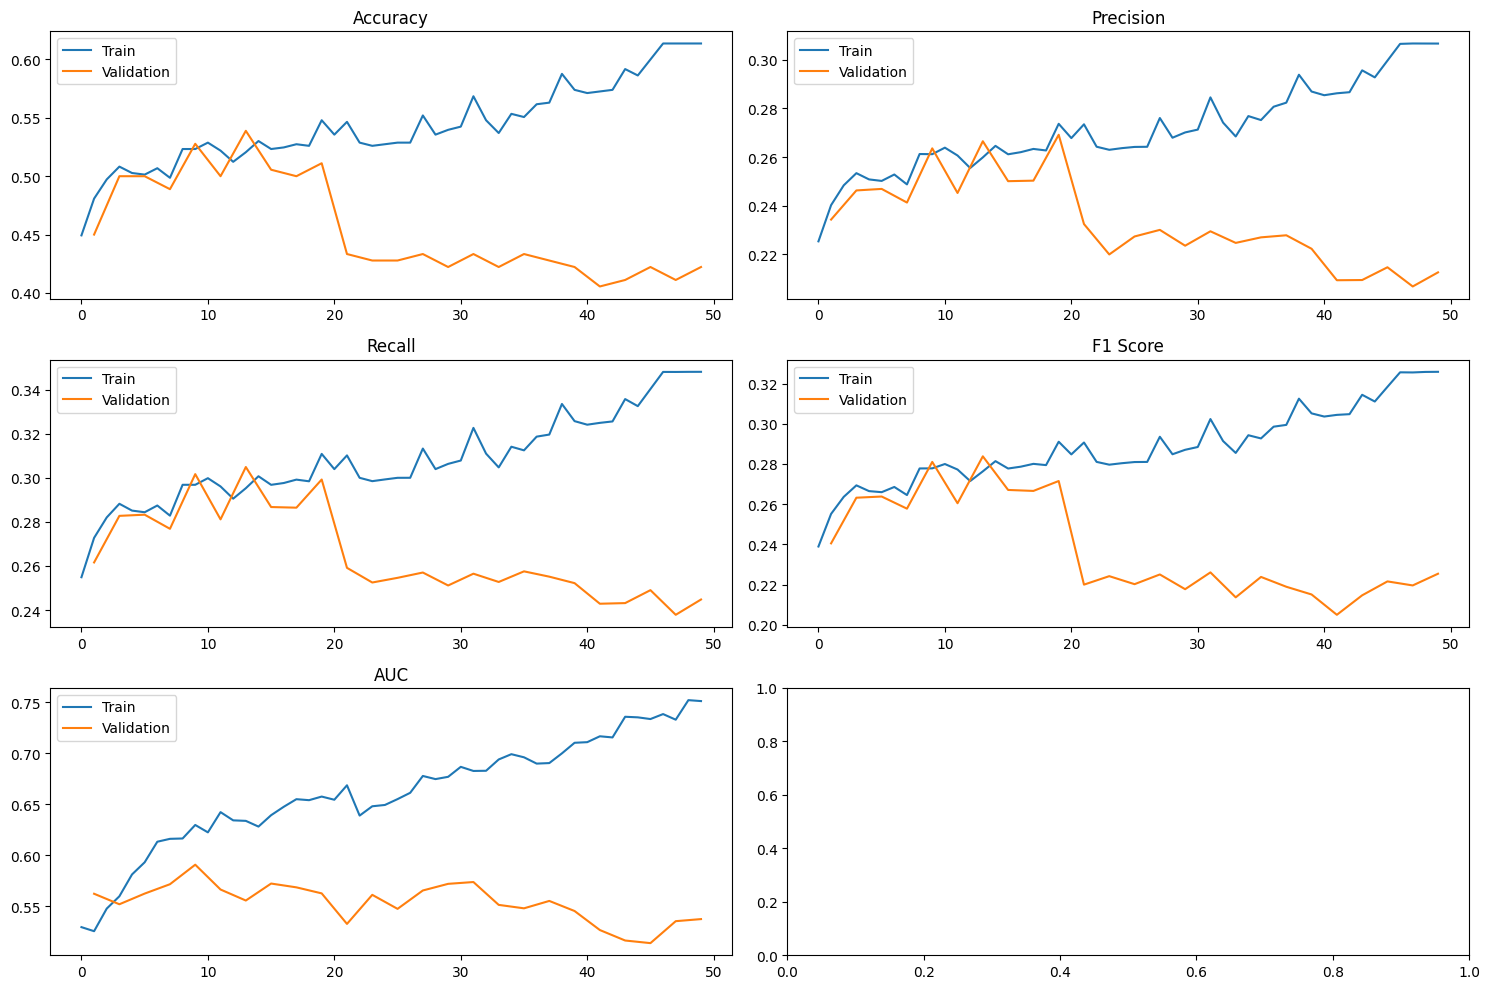

In [3]:
train_performance = get_performace('outputs/train_records_fold_0_epoch_49_momentum_0.9.csv')
val_performance = get_performace('outputs/val_records_fold_0_epoch_49_momentum_0.9.csv')

# plot the metrics
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']):
    ax[i//2, i%2].plot(list(train_performance.keys()), [train_performance[epoch][metric] for epoch in train_performance.keys()], label='Train')
    ax[i//2, i%2].plot(list(val_performance.keys()), [val_performance[epoch][metric] for epoch in val_performance.keys()], label='Validation')
    ax[i//2, i%2].set_title(metric)
    ax[i//2, i%2].legend()
plt.tight_layout()
plt.show()


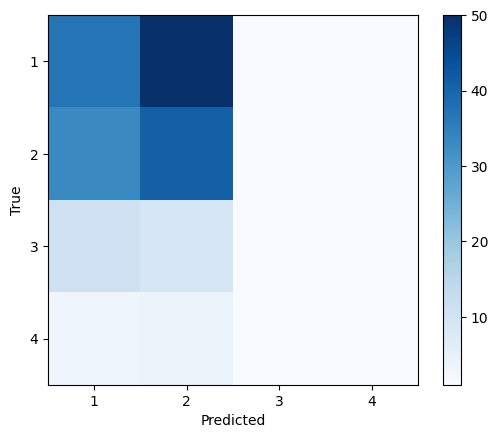

In [20]:
# plot the confusion matrix of the last epoch
cm = val_performance[49]['Confusion Matrix']
cm = cm + 1

plt.imshow(cm, cmap='Blues')
plt.colorbar()

# Set the x and y ticks to show only whole numbers
xticks = np.arange(1, cm.shape[1] + 1)
yticks = np.arange(1, cm.shape[0] + 1)
plt.xticks(xticks - 1, xticks)
plt.yticks(yticks - 1, yticks)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()